In [1]:
# import libraries
import BioSimSpace as BSS
import os
import sys
import glob
import csv
import numpy as np
import networkx as nx
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale, MinMaxScaler
import itertools as it

import pipeline

from pipeline.prep import *
from pipeline.utils import *

pipeline.__file__

import random
import math
import pandas as pd
import subprocess

fwf_path = (
    "/home/anna/Documents/september_2022_workshops/freenrgworkflows/networkanalysis"
)
if fwf_path not in sys.path:
    sys.path.insert(1, fwf_path)

import networkanalysis

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from scipy.stats import sem as sem
from scipy.stats import bootstrap, norm
from scipy.stats import spearmanr
import scipy.stats as _stats

from sklearn.preprocessing import minmax_scale

INFO:rdkit:Enabling RDKit 2024.03.5 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
/home/anna/mambaforge/envs/pipeline_annamherz/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [24]:
protein = "mcl1"

exec_folder = f"/home/anna/Documents/benchmark/reruns/{protein}/execution_model"

##### <span style="color:teal">Comparing lomap and the rbfenn</span>  


In [ ]:
# get a list of the perts in each and all together
perts_lomap = []
perts_rbfenn = []
perts = []

file_a = f"{exec_folder}/network_lomap.dat"
# file_a = f"a-optimal-lomap.csv"
file_b = f"{exec_folder}/network_rbfenn.dat"
# file_b = f"d-optimal-lomap.csv"

perts_rbfenn, ligs = pipeline.utils.get_info_network(file_a)
perts_lomap, ligs = pipeline.utils.get_info_network(file_b)
perts = perts_rbfenn + perts_lomap

# write a file that contains the combined perts, directions are distinct
combined_perts = []
filtered_out = 0
filtered_perts = []
for pert in perts:
    if not pert in combined_perts:
        combined_perts.append(pert)
    else:
        filtered_out += 1
        filtered_perts.append(pert)
print(
    f"Removed {filtered_out} duplicate perts between lomap and rbfenn to give {len(combined_perts)} combined perts."
)

# write a file that contains the unique perts, 1 direction only.
filtered_perts = []
filtered_out = 0
for pert in combined_perts:
    inv_pert = pert.split("~")[1] + "~" + pert.split("~")[0]

    if not pert in filtered_perts and not inv_pert in filtered_perts:
        filtered_perts.append(pert)
    else:
        filtered_out += 1
print(
    f"Removed {filtered_out} inverse perts to give {len(filtered_perts)} unique perts, one direction only."
)

# get the perts that are unique to each
unique_perts = []
unique_out_lomap = 0
unique_out_rbfenn = 0
shared_out = 0

for pert in perts_lomap:
    inv_pert = pert.split("~")[1] + "~" + pert.split("~")[0]

    if not pert in perts_rbfenn and not inv_pert in perts_rbfenn:
        unique_perts.append((pert, "lomap"))
        unique_out_lomap += 1

for pert in perts_rbfenn:
    inv_pert = pert.split("~")[1] + "~" + pert.split("~")[0]

    if not pert in perts_lomap and not inv_pert in perts_lomap:
        unique_perts.append((pert, "rbfenn"))
        unique_out_rbfenn += 1

for pert in combined_perts:
    inv_pert = pert.split("~")[1] + "~" + pert.split("~")[0]

    if pert in perts_lomap or inv_pert in perts_lomap:
        if pert in perts_rbfenn or inv_pert in perts_rbfenn:
            unique_perts.append((pert, "shared"))
            shared_out += 1


print(
    f"There are {unique_out_lomap} pert(s) unique to lomap and {unique_out_rbfenn} pert(s) unique to rbfenn."
)
print(f"There are {shared_out} pert(s) shared between lomap and rbfenn")

Removed 9 duplicate perts between lomap and rbfenn to give 42 combined perts.
Removed 0 inverse perts to give 42 unique perts, one direction only.
There are 10 pert(s) unique to lomap and 23 pert(s) unique to rbfenn.
There are 9 pert(s) shared between lomap and rbfenn


In [11]:
from pipeline.utils._network import get_info_network
prot_dict = {}
for prot in ["tyk2", "mcl1", "p38"]:  # , "cmet", "syk", "hif2a"
    prot_dict[prot] = {}
    for network in ["lomap", "rbfenn","flare"]:
        try:
            exec_folder = f"/home/anna/Documents/benchmark/reruns/{prot}/execution_model"
            perts,ligs = get_info_network(
                net_file=f"{exec_folder}/network_{network}.dat",
            )
            prot_dict[prot][network] = len(perts)/len(ligs)
        except:
            prot_dict[prot][network] = 0
# for prot in ["cmet", "syk", "hif2a"]:
#     prot_dict[prot]["flare"] = 0

In [ ]:
df = pd.DataFrame.from_dict(prot_dict).T
df.plot.bar(color=["darkslateblue", "purple", "orchid", "lavender"],)
plt.legend(loc='lower right')
plt.title("perturbations/ligands")

In [ ]:
# manually combined all perts,
perts_all, ligs = pipeline.utils.get_info_network("tyk2_all_perts.dat")
print(len(perts_all))
# print(perts_all)

all_perts = []

for pert in perts_all:
    inv_pert = pert.split("~")[1] + "~" + pert.split("~")[0]

    if pert in combined_perts or inv_pert in combined_perts:
        all_perts.append((pert, "old"))
    else:
        all_perts.append((pert, "new"))

df = pd.DataFrame(all_perts)

df.loc[df[1] == "new"]

In [28]:
with open(f"{exec_folder}/combined_perts_rlf.dat", "w") as writefile:
    writer = csv.writer(writefile)
    for pert in combined_perts:
        writer.writerow([pert])
print(f"Total number of combined perturbations: {len(combined_perts)}")

# with open(f"{exec_folder}/filtered_perts.dat", "w") as writefile:
#     writer = csv.writer(writefile)
#     for pert in filtered_perts:
#         writer.writerow([pert])
# print(f"Total number of filtered perturbations: {len(filtered_perts)}")

# # write a file for the different perts
# with open(f"{exec_folder}/unique_perts.dat", "w") as writefile:
#     writer = csv.writer(writefile)
#     for pert in unique_perts:
#         writer.writerow([pert[0], pert[1]])
# print(
#     f"Total number of unique perturbations: {len(unique_perts)} (lomap: {unique_out_lomap}, rbfenn: {unique_out_rbfenn})"
# )
# print(f"Total number of shared perturbations: {shared_out}")

Total number of combined perturbations: 42


In [ ]:
# make a dicitonary of the perts for plotting the nx graph
both_pert_networks_dict = {}

for pert in filtered_perts:
    inv_pert = pert.split("~")[1] + "~" + pert.split("~")[0]

    if pert in perts_lomap and pert in perts_rbfenn:
        both_pert_networks_dict[pert] = "both"
    elif inv_pert in perts_lomap and pert in perts_rbfenn:
        both_pert_networks_dict[pert] = "both"
    elif pert in perts_lomap and pert not in perts_rbfenn:
        both_pert_networks_dict[pert] = "lomap"
    elif inv_pert in perts_lomap and pert not in perts_rbfenn:
        both_pert_networks_dict[pert] = "lomap"
    elif pert not in perts_lomap and pert in perts_rbfenn:
        both_pert_networks_dict[pert] = "rbfenn"
    elif inv_pert not in perts_lomap and pert in perts_rbfenn:
        both_pert_networks_dict[pert] = "rbfenn"

# create dict for images for the nx graph
image_dict = {}
# list files in inputs
input_files_for_image = sorted(
    os.listdir(f"{exec_folder}/visualise_network_lomap/inputs")
)
for in_file in input_files_for_image:
    lig_name_list = in_file.split("_")[1:]
    lig_name = "_".join(lig_name_list).split(".")[0]
    lig_number = in_file.split("_")[0]
    image_dict[lig_name] = lig_number

In [ ]:
# Generate the graph.
graph = nx.Graph()

# Loop over the nligands and add as nodes to the graph.
for lig in ligand_names:
    img = f"{exec_folder}/visualise_network_lomap/images/{image_dict[lig]}.png"
    graph.add_node(lig, image=img, label=lig, labelloc="t")

# make a dict of colours
# navy teal  #CC00CC
# clear is '#FF000000'
colour_dict = {"both": "navy", "lomap": "teal", "rbfenn": "hotpink"}

# Loop over the edges in the dictionary and add to the graph.
for edge in both_pert_networks_dict:
    graph.add_edge(
        edge.split("~")[0],
        edge.split("~")[1],
        color=colour_dict[both_pert_networks_dict[edge]],
    )

# Plot the networkX graph.
pos = nx.kamada_kawai_layout(graph)
colours = nx.get_edge_attributes(graph, "color").values()

plt.figure(figsize=(12, 12), dpi=150)
nx.draw(
    graph,
    pos,
    edge_color=colours,
    width=1,
    linewidths=5,
    node_size=2000,
    node_color="skyblue",
    font_size=12,
    labels={node: node for node in graph.nodes()},
)

plt.savefig(f"{exec_folder}/compared_networks_no_images.png", dpi=300)
# plt.show()

# Convert to a dot graph.
dot_graph = nx.drawing.nx_pydot.to_pydot(graph)

# Write to a PNG.
network_plot = f"{exec_folder}/compared_networks.png"
dot_graph.write_png(network_plot)

# Create a plot of the network.
img = mpimg.imread(network_plot)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(img)

In [ ]:
# calculate the lomap score for the combined network file (unfiltered)
combined_pert_network_dict = {}

for pert in combined_perts:
    lig_a = pert.split("~")[0]
    lig_b = pert.split("~")[1]
    # then, we need to find this index for our chosen edge that we are adding.
    lig_a_index = ligand_names.index(lig_a)
    lig_b_index = ligand_names.index(lig_b)
    # finally, we need to calculate this single lomap score.
    single_transformation, single_lomap_score = BSS.Align.generateNetwork(
        [ligands[lig_a_index], ligands[lig_b_index]],
        names=[ligand_names[lig_a_index], ligand_names[lig_b_index]],
        plot_network=False,
    )
    print(f"LOMAP score for {lig_a} to {lig_b} is {single_lomap_score[0]} .")
    combined_pert_network_dict[(lig_a, lig_b)] = single_lomap_score[0]

In [ ]:
# write the combined to a different network file

with open(f"{exec_folder}/network_combined.dat", "w") as network_file:
    writer = csv.writer(network_file, delimiter=" ")

    for pert, score in combined_pert_network_dict.items():
        # # based on the provided (at top of notebook) lambda allocations and LOMAP threshold, decide allocation.
        # if score == None or score < float(node.getInput("LOMAP Threshold")):
        #     num_lambda = node.getInput("DiffLambdaWindows")
        # else:
        #     num_lambda = node.getInput("LambdaWindows")

        num_lambda = node.getInput("LambdaWindows")

        # given the number of allocated lambda windows, generate an array for parsing downstream.
        lam_array_np = np.around(np.linspace(0, 1, int(num_lambda)), decimals=5)

        # make the array into a format readable by bash.
        lam_array = (
            str(lam_array_np)
            .replace("[ ", "")
            .replace("]", "")
            .replace("  ", ",")
            .replace("\n", "")
        )

        # write out both directions for this perturbation.
        if engine == "ALL":
            for eng in BSS.FreeEnergy.engines():
                writer.writerow([pert[0], pert[1], len(lam_array_np), lam_array, eng])
        else:
            writer.writerow([pert[0], pert[1], len(lam_array_np), lam_array, engine])
        # writer.writerow([pert[1], pert[0], len(lam_array_np), lam_array, engine])

### generate a and d optimal networks

code in other_workflows.
this has 4 files
exp_dg - this is just experimental dGs
pairwise_fep - this is the results from the fep (A, D, lit)
literature designed pairs - this is the pairs from literature and their fep ddG
ap_matrix - this is the matrix of the ligands with their similarity.

scripts are in R

In [ ]:
protein = "p38"

exec_folder = f"/home/anna/Documents/benchmark/reruns/{protein}/execution_model"
# exec_folder = f"/home/anna/Documents/benchmark/{protein}_benchmark/execution_model"

In [ ]:
def scaleArray(arr):
    """Scales an array to be the inverse in the range [0-1]."""

    # normalise to the range 0-1.
    return minmax_scale(1 / arr, feature_range=(0.03, 1))

In [ ]:
# to generate a network, need to make matrix as for cdk2

links_file = f"{exec_folder}/RBFENN/links_file.in"

# rbfenn file

value_dict = {}

# need to normalise the rbfenn so less close to 0 as otherwise is not able to det(matrix) way more than 0 when using the R script.

with open(links_file, "r") as f:
    for line in f:
        lig0 = line.split(" ")[0].strip()
        lig1 = line.split(" ")[1].strip()
        score = line.split(" ")[2].strip()
        if lig0 not in value_dict.keys():
            value_dict[lig0] = {}
            value_dict[lig0][lig1] = score
        else:
            value_dict[lig0][lig1] = score

pd.options.display.float_format = "{:,.5f}".format
df = pd.DataFrame(value_dict).fillna(1)

df = df.sort_index()
df = df.reindex(sorted(df.columns), axis=1)

# df.to_csv(
#     f"{exec_folder}/{protein}_rbfenn_matrix.csv",
#     index_label="ID",
# )
df.to_csv(f"/home/anna/Documents/other_workflows/yang2020_optimal_designs/me/{protein}/{protein}_rbfenn_matrix.csv", index_label="ID")


In [ ]:
# lomap file

value_dict = {}

# initialise pipeline at top of file
pl = initialise_pipeline()
# where the ligands for the pipeline are located. These should all be in the same folder in sdf format
pl.ligands_folder(f"/home/anna/Documents/benchmark/inputs/reruns/{protein}/ligands")
# where the pipeline should be made
pl.main_folder("/home/anna/Documents/benchmark/test")
pl.setup_ligands()

for lig0, lig1 in it.product(list(pl.ligands_dict.keys()), list(pl.ligands_dict.keys())):
    if lig0 != lig1:
        print(lig0,lig1)
        single_transformation, score = BSS.Align.generateNetwork(
            [pl.ligands_dict[lig0], pl.ligands_dict[lig1]],
            names=[lig0, lig1],
            plot_network=False,
            links_file=None,
        )
        if lig0 not in value_dict.keys():
            value_dict[lig0] = {}
            value_dict[lig0][lig1] = score[0]
        else:
            value_dict[lig0][lig1] = score[0]

df = pd.DataFrame(value_dict).fillna(1)


In [ ]:
# arr = scaleArray(df.to_numpy())
# df_arr = pd.DataFrame(arr, columns=list(pl.ligands_dict.keys()), index=list(pl.ligands_dict.keys()))
df_arr = df

# df.to_csv(f"{exec_folder}/{protein}_lomap_matrix.csv", index_label="ID")
df_arr.to_csv(f"/home/anna/Documents/other_workflows/yang2020_optimal_designs/me/{protein}/{protein}_lomap_matrix.csv", index_label="ID")

### expected performance of lomap vs rbfenn

run in python script already

In [8]:
protein = "mcl1"

exec_folder = f"/home/anna/Documents/benchmark/reruns/{protein}/execution_model"
pipeline.utils.validate.folder_path(
    f"/home/anna/Documents/benchmark/reruns/{protein}/stats", create=True
)

'/home/anna/Documents/benchmark/reruns/mcl1/stats'

In [9]:
# looking at the different generated networks

# network processing
net_proc_dict = {}
net_proc_dict_err = {}
for network in ["lomap-a-optimal", "lomap-d-optimal", "rbfenn-a-optimal", "rbfenn-d-optimal" ]: # "lomap", "rbfenn", "flare", 
    net_proc_dict[network] = {}
    net_proc_dict_err[network] = {}
    # for protein in ["mcl1"]:  # , "mcl1", "p38"
    print(protein)
    for method in ["mae_dG", "mae_ddG", "rmse_ddG", "r2_dG", "ktau_dG", ]: # "r2_dG", "ktau_dG"
        exec_folder = f"/home/anna/Documents/benchmark/reruns/{protein}/execution_model"
        # print(network, protein)
        file = f"{exec_folder}/network_{network}_stats_random_ref.csv"
        df = pd.read_csv(file, sep=",")
        # print(df.columns)
        #  "mae_dG", "mae_ddG", "rmse_dgG", "r2_dG", "ktau_dG",
        data = df[method].to_numpy()  # mae_ddG for perts
        # more than 30
        lower_ci, upper_ci = _stats.norm.interval(
            confidence=0.95, loc=np.mean(data), scale=_stats.sem(data)
        )
        data_point = (np.mean(data), np.std(data), (lower_ci, upper_ci), data)
        print(f"{network}, {method}, {np.mean(data):.2f} ({lower_ci:.2f}, {upper_ci:.2f})") # , {np.std(data):.2f}, 
        net_proc_dict[network][method] = np.mean(data)
        # net_proc_dict_err[network][method] = np.std(data)
        net_proc_dict_err[network][method] = (lower_ci, upper_ci)

# # two sample ttest from stats
# _stats.ttest_ind_from_stats(
#     mean1=net_proc_dict["lomap"][protein][0],
#     # rbfenn
#     mean2=net_proc_dict["rbfenn"][protein][0],
#     std1=net_proc_dict["lomap"][protein][1],
#     std2=net_proc_dict["rbfenn"][protein][1],
#     nobs1=5000,
#     nobs2=5000,
# )

# for network in ["lomap", "rbfenn"]:

#             print(network)
#             mean_list = []
#             for protein in ["tyk2", "mcl1", "p38"]:
#                 mean_list.append(net_proc_dict[network][protein][0])
#             # if less than 30
#             lower_ci,upper_ci = stats.t.interval(confidence=0.95, df=len(mean_list)-1,
#                                                 loc=np.mean(mean_list), # mean
#                                                 scale=stats.sem(mean_list), # mae
#                                                 )
#             print(mean_list)
#             print(np.mean(mean_list), np.std(mean_list), (lower_ci, upper_ci))

# paired t-test to see if sig diff - if matched pairs. No matched pairs for the different networks.
# stats.ttest_rel()
# if p value less than 0.05  can reject null hypothesis ie the values are different
# stats.ttest_rel(
#                 a=[0.6347933321260876, 0.7627511083731504, 0.8173187836332945],
#                 b=[0.578309333383623, 0.849541385123305, 0.6489798749437058])

mcl1
lomap-a-optimal, mae_dG, 0.71 (0.71, 0.72)
lomap-a-optimal, mae_ddG, 0.80 (0.79, 0.81)
lomap-a-optimal, rmse_ddG, 0.98 (0.98, 0.99)
lomap-a-optimal, r2_dG, 0.65 (0.64, 0.65)
lomap-a-optimal, ktau_dG, 0.61 (0.61, 0.61)
mcl1
lomap-d-optimal, mae_dG, 0.86 (0.85, 0.87)
lomap-d-optimal, mae_ddG, 0.80 (0.79, 0.80)
lomap-d-optimal, rmse_ddG, 0.98 (0.98, 0.99)
lomap-d-optimal, r2_dG, 0.59 (0.58, 0.60)
lomap-d-optimal, ktau_dG, 0.56 (0.56, 0.57)
mcl1
rbfenn-a-optimal, mae_dG, 0.59 (0.58, 0.59)
rbfenn-a-optimal, mae_ddG, 0.80 (0.79, 0.80)
rbfenn-a-optimal, rmse_ddG, 0.99 (0.98, 0.99)
rbfenn-a-optimal, r2_dG, 0.73 (0.72, 0.73)
rbfenn-a-optimal, ktau_dG, 0.67 (0.66, 0.67)
mcl1
rbfenn-d-optimal, mae_dG, 0.61 (0.60, 0.62)
rbfenn-d-optimal, mae_ddG, 0.80 (0.79, 0.81)
rbfenn-d-optimal, rmse_ddG, 0.99 (0.98, 1.00)
rbfenn-d-optimal, r2_dG, 0.73 (0.72, 0.73)
rbfenn-d-optimal, ktau_dG, 0.66 (0.66, 0.67)


/tmp/ipykernel_541898/1206966797.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_lower = df - df_err.applymap(lambda x: x[0])
/tmp/ipykernel_541898/1206966797.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_upper = df_err.applymap(lambda x: x[1]) - df


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:24                                                                                   │
│                                                                                                  │
│   21 │   │   )                                                                                   │
│   22 plt.xlabel("statistic")                                                                     │
│   23 plt.ylabel("Value (kcal/mol)")                                                              │
│ ❱ 24 ax.set_xticklabels(["MAE dG", "MAE ddG", "RMSE ddG"])                                       │
│   25 #                                                                                           │
│   26                                                                                             │
│                                                                                                  │
│ /home/anna/mambaforge/envs/pipeline_annamherz/lib/python3.10/site-packages/matplotlib/axes/_base │
│ .py:74 in wrapper                                                                                │
│                                                                                                  │
│     71 │   │   get_method = attrgetter(f"{self.attr_name}.{self.method_name}")                   │
│     72 │   │                                                                                     │
│     73 │   │   def wrapper(self, *args, **kwargs):                                               │
│ ❱   74 │   │   │   return get_method(self)(*args, **kwargs)                                      │
│     75 │   │                                                                                     │
│     76 │   │   wrapper.__module__ = owner.__module__                                             │
│     77 │   │   wrapper.__name__ = name                                                           │
│                                                                                                  │
│ /home/anna/mambaforge/envs/pipeline_annamherz/lib/python3.10/site-packages/matplotlib/axis.py:20 │
│ 71 in set_ticklabels                                                                             │
│                                                                                                  │
│   2068 │   │   │   # Passing [] as a list of labels is often used as a way to                    │
│   2069 │   │   │   # remove all tick labels, so only error for > 0 labels                        │
│   2070 │   │   │   if len(locator.locs) != len(labels) and len(labels) != 0:                     │
│ ❱ 2071 │   │   │   │   raise ValueError(                                                         │
│   2072 │   │   │   │   │   "The number of FixedLocator locations"                                │
│   2073 │   │   │   │   │   f" ({len(locator.locs)}), usually from a call to"                     │
│   2074 │   │   │   │   │   " set_ticks, does not match"                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number 
of labels (3).

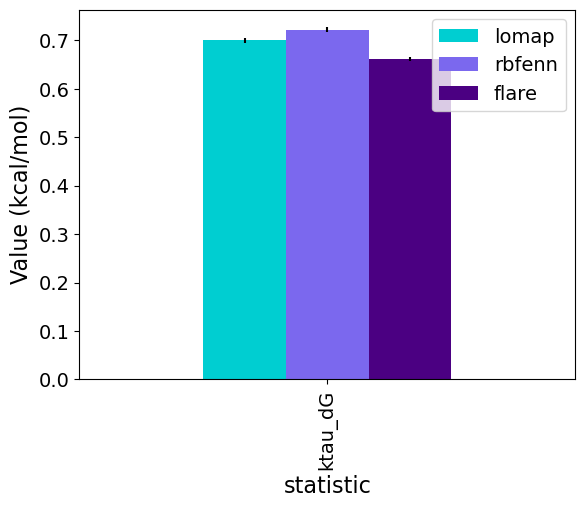

In [41]:
df = pd.DataFrame.from_dict(net_proc_dict)
df_err = pd.DataFrame.from_dict(net_proc_dict_err)

drop_list = ["mae_dG", "r2_dG", "mae_ddG", "rmse_ddG"]
df.drop(index=drop_list, inplace=True)
df_err.drop(index=drop_list, inplace=True)

drop_list = ["lomap-a-optimal", "lomap-d-optimal", "rbfenn-a-optimal", "rbfenn-d-optimal"]
df.drop(columns=drop_list, inplace=True)
df_err.drop(columns=drop_list, inplace=True)

# if CI in cell above:
df_lower = df - df_err.applymap(lambda x: x[0])
df_upper = df_err.applymap(lambda x: x[1]) - df
df_err = np.stack([df_lower.T.values, df_upper.T.values], axis=1)

ax = df.plot.bar(yerr=df_err,
        color=["darkturquoise",
         "mediumslateblue","indigo"], #"paleturquoise", "cadetblue",'mediumslateblue'
        #colormap="plasma"
        )
plt.xlabel("statistic")
plt.ylabel("Value (kcal/mol)")
ax.set_xticklabels(["MAE dG", "MAE ddG", "RMSE ddG"])
# 

In [ ]:
# make best fit dict
best_fit_dict = {}

for protein in ["tyk2", "mcl1", "p38"]:
    exec_folder = f"/home/anna/Documents/benchmark/reruns/{protein}/execution_model"
    pipeline.utils.validate.folder_path(
        f"/home/anna/Documents/benchmark/reruns/{protein}/stats", create=True
    )

    stats = "mse_dG"  # mae_dG,mae_ddG,mse_dG,mse_ddG,spearman_coeff,spearman_p
    for name in [
        "lomap",
        "rbfenn",
        "flare"
        # "lomap-a-optimal",
        # "rbfenn-a-optimal",
        # "lomap-d-optimal",
        # "rbfenn-d-optimal",
    ]:
        print(name)
        df = pd.read_csv(f"{exec_folder}/network_{name}_stats.csv", header="infer")

        x = np.array(df[stats])
        no_bins = abs(round(math.sqrt(len(x))))

        # Fit a normal distribution to the data, mean and standard deviation
        mu, std = norm.fit(x)

        # plot histogram
        plt.hist(
            x, bins=no_bins, density=True, alpha=0.7, color="skyblue", edgecolor="grey"
        )

        # Plot the PDF.
        xmin, xmax = plt.xlim()

        mu, std = norm.fit(x)
        x = np.linspace(xmin, xmax, 100)
        y = norm.pdf(x, mu, std)

        best_fit_dict[f"{protein}_{name}"] = ((x, y), mu, std)

In [ ]:
col_dict = {}

for key in best_fit_dict.keys():
    hexadecimal_alphabets = "0123456789ABCDEF"
    color = "#" + "".join([random.choice(hexadecimal_alphabets) for j in range(6)])
    col_dict[key] = color

In [ ]:
# plot the differnet neworks

# plot the distributions
fig, ax = plt.subplots(figsize=(10, 10))

lines = []
mu_std_string = ""

for name in best_fit_dict.keys():
    col = col_dict[name]
    plt.plot(
        best_fit_dict[name][0][0],
        best_fit_dict[name][0][1],
        "k",
        linewidth=2,
        color=col,
    )
    lines += plt.plot(0, 0, c=col, label=name)
    mu_std_string += f"\n{name} : mu = {best_fit_dict[name][1]:.3f} , std = {best_fit_dict[name][2]:.3f}"

    ax.axvspan(
        best_fit_dict[name][1] + best_fit_dict[name][2],
        best_fit_dict[name][1] - best_fit_dict[name][2],
        color=col,
        alpha=0.2,
    )
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc="upper right")

plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title(f"{stats}\n{mu_std_string}")
plt.savefig(
    # f"/home/anna/Documents/benchmark/{protein}_benchmark/stats/dist_errors_networks_{stats}_net.png",
    f"/home/anna/Documents/benchmark/dist_errors_networks_{stats}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()